# Imports

In [ ]:
from skimage.segmentation import watershed, felzenszwalb
from skimage.filters import sobel
import pandas as pd
from pathlib import Path
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.filters import rank
from scipy import ndimage as ndi
from skimage.morphology import disk
import sklearn.metrics

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Handling the data

In [ ]:
# Load the train labels
# Note the transpose!
data_dir = Path("drive/MyDrive/Raidium - Challenge data 2023/")
labels_train = pd.read_csv(data_dir  / "Y_train2.csv", index_col=0).T

In [ ]:
# Here is a function to load the data
def load_dataset(dataset_dir):
    dataset_list = []
    # Note: It's very important to load the images in the correct numerical order!
    for image_file in list(sorted(Path(dataset_dir).glob("*.png"), key=lambda filename: int(filename.name.rstrip(".png")))):
        dataset_list.append(cv2.imread(str(image_file), cv2.IMREAD_GRAYSCALE))
    return np.stack(dataset_list, axis=0)

In [ ]:
# Load the train and test sets
# If you've put the shortcut directly in your drive, this should work out of the box
# Else, edit the path
data_dir = Path("drive/MyDrive/Raidium - Challenge data 2023/")
data_train = load_dataset(data_dir / "X_train")
data_test = load_dataset(data_dir / "X_test")

In [ ]:
# The train data is a numpy array of 1000 images of 512*512
print(f"X_train shape: {data_train.shape}")
# The train label is a dataframe of 1000 rows with 262144 (=512x512) columns
print(f"Y_train shape: {labels_train.shape}")
# The test  data is a numpy array of 500 images of 512*512
print(f"X_test shape: {data_test.shape}")

X_train shape: (2000, 512, 512)
Y_train shape: (2000, 262144)
X_test shape: (500, 512, 512)


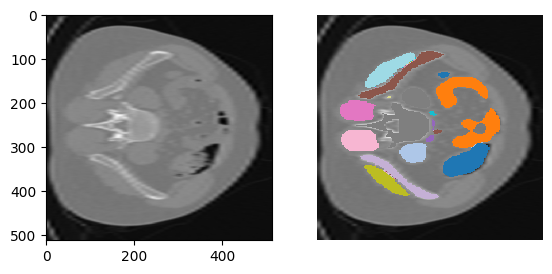

In [ ]:
# Let's display some data
# Here is a function to display side by side a slide and a segmented mask
def plot_slice_seg(slice_image, seg):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(slice_image, cmap="gray")
    axes[1].imshow(slice_image, cmap="gray")
    seg_masked = np.ma.masked_where(seg.reshape((512,512)) == 0, (seg.reshape((512,512))))
    axes[1].imshow(seg_masked, cmap="tab20")
    plt.axis("off")

# Let's try it on a slide and ites segmentation mask
# Note: we have to reshape the rows of the dataframe into a 512*512 matrix
plot_slice_seg(data_train[0], labels_train.iloc[0].values.reshape((512,512)))

# Let's compute a baseline

In [ ]:
# Let's take a very basic watershed baseline
def compute_baseline_one_sample(data_slice):
    edges = sobel(data_slice)
    denoised = rank.median(data_slice, disk(2))
    markers = rank.gradient(denoised, disk(5)) < 20
    markers = ndi.label(markers)[0]
    label_predicted = watershed(edges, markers=markers, compactness=0.0001)
    return label_predicted

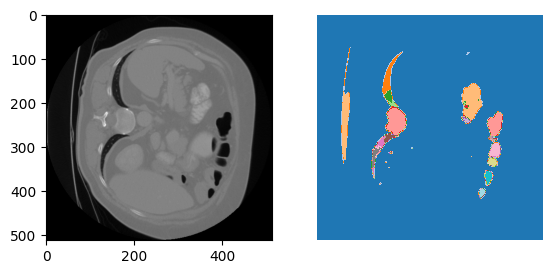

In [ ]:
# Let's display the results
# Not too bad!
plot_slice_seg(data_train[2], compute_baseline_one_sample(data_train[2]))

## Let's measure its performances

In [ ]:
# Compute the baseline on a whole dataset
def compute_baseline(dataset: np.array):
    labels_predicted_list = []
    for data_index in tqdm(range(len(dataset))):
        data_slice = dataset[data_index]
        label_predicted = compute_baseline_one_sample(data_slice)
        labels_predicted_list.append(label_predicted)
    return pd.DataFrame(np.stack(labels_predicted_list, axis=0).reshape((len(labels_predicted_list), -1)))

In [ ]:
# Let's create a validation set first: the 200 first images of the train set
data_val = data_train[:200]
labels_val = labels_train.iloc[:200]

In [ ]:
# Compute baseline on a few train data
labels_val_predicted_baseline = compute_baseline(data_val)

100%|██████████| 200/200 [01:04<00:00,  3.09it/s]


In [ ]:
def rand_index_dataset(y_true_df: pd.DataFrame, y_pred_df: pd.DataFrame) -> float:
    """Compute the individual rand index for each sample in the dataset and then average it"""
    individual_rand_index = []
    for row_index in range(y_true_df.values.shape[0]):
        labels = y_true_df.values[row_index]
        preds = y_pred_df.values[row_index]
        individual_rand_index.append(sklearn.metrics.adjusted_rand_score(labels, preds))

    return np.mean(individual_rand_index)

In [ ]:
# Compute the metric on the validation set
rand_index_dataset(labels_val, labels_val_predicted_baseline)
# We get 0.08 ; Pretty bad, but room for improvements!


0.08768726985663285

### Let's try with another dummy model that we will finetune

In [ ]:
def felzenszwalb_one_sample(data_slice, scale=1, sigma=0.8, min_size=20):
    label_predicted = felzenszwalb(data_slice, scale=scale, sigma=sigma, min_size=min_size)
    return label_predicted

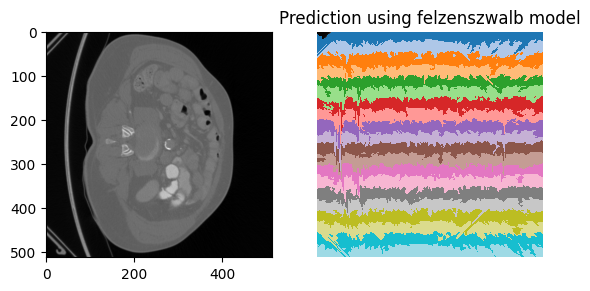

In [ ]:
plot_slice_seg(data_train[0], felzenszwalb_one_sample(data_train[0]))
plt.title('Prediction using felzenszwalb model'); # Awful

In [ ]:
def compute_felzenszwalb(dataset: np.array, scale=1, sigma=0.8, min_size=20, verbosity=True):
    labels_predicted_list = []
    s = 0
    for index in range(np.shape(dataset)[0]):
        data_slice = dataset[index]
        label_predicted = felzenszwalb_one_sample(data_slice, scale=scale, sigma=sigma, min_size=min_size)
        labels_predicted_list.append(label_predicted)
        if verbosity:
            if s%50 == 0:
                print(f"Image {s}/{np.shape(dataset)[0]} processed")
        s =  s+1
    return pd.DataFrame(np.stack(labels_predicted_list, axis=0).reshape((len(labels_predicted_list), -1)))

In [ ]:
# Let's create a validation set first: the 200 first images of the train set
data_val = data_train[:200]
labels_val = labels_train.iloc[:200]

In [ ]:
labels_val_predicted_felzenszwalb = compute_felzenszwalb(data_val)

Image 0/200 processed
Image 50/200 processed
Image 100/200 processed
Image 150/200 processed


In [ ]:
# Compute the metric on the validation set
rand_index_dataset(labels_val, labels_val_predicted_felzenszwalb.sample(200))

# As planned, it is awfully awful

0.006095309706960556

##A chier mais si on essaye de corriger les paramètres

In [ ]:
def grid_search_felzenszwalb(scale_range, sigma_range, min_size_range, data_size):
    nb_possibilities = len(scale_range) * len(sigma_range) * len(min_size_range)
    print(f"Grid search will test {nb_possibilities} combinations")
    s = 0
    scores_dict = {}
    data = data_train[:data_size]
    labels = labels_train.iloc[:data_size]
    for scale in scale_range:
        for sigma in sigma_range:
            for min_size in min_size_range:
                prediction = compute_felzenszwalb(data, scale, sigma, min_size, verbosity=False)
                score = rand_index_dataset(labels, prediction.sample(data_size))
                scores_dict[score] = {'scale_param':scale, 'sigma_param':sigma, 'min_size_param':min_size}
                s = s+1
                if s%100 == 0:
                    print(f"Combination {s}/{nb_possibilities}")
    best_params = scores_dict[max(scores_dict.keys())]
    return best_params

In [ ]:
scale_range = np.arange(1, 100, 10) # Let's try on 10 for computational reasons
sigma_range = np.arange(0.1, 1, 0.1)
min_size_range = np.arange(100, 2000, 100)
data_size = 10
grid_search_felzenszwalb(scale_range, sigma_range, min_size_range, data_size)

Grid search will test 1710 combinations
Combination 100/1710
Combination 200/1710
Combination 300/1710
Combination 400/1710
Combination 500/1710
Combination 600/1710
Combination 700/1710
Combination 800/1710
Combination 900/1710
Combination 1000/1710
Combination 1100/1710
Combination 1200/1710
Combination 1300/1710
Combination 1400/1710
Combination 1500/1710
Combination 1600/1710
Combination 1700/1710


{'scale_param': 31, 'sigma_param': 0.9, 'min_size_param': 900}

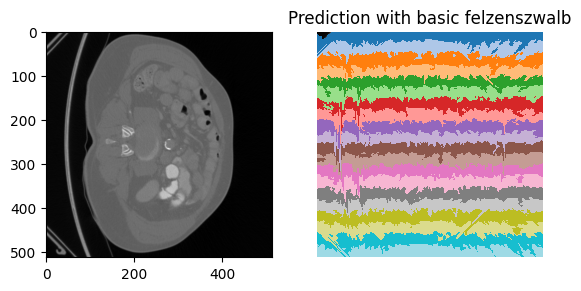

In [ ]:
plot_slice_seg(data_train[0], felzenszwalb(data_train[0]))
plt.title('Prediction with basic felzenszwalb');  # Now let's compare the previous dummy example here

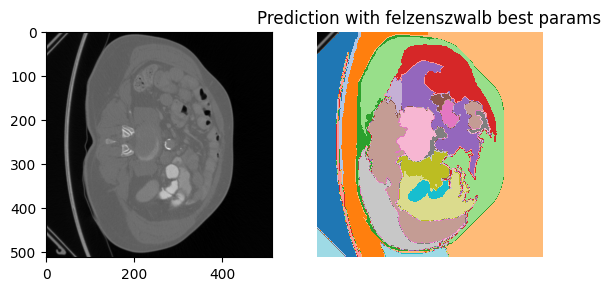

In [ ]:
plot_slice_seg(data_train[0], felzenszwalb_one_sample(data_train[0], scale=51, sigma=0.9, min_size=900))
plt.title('Prediction with felzenszwalb best params'); # With the dummy example finetuned which is much better !

In [ ]:
gs_labels_val_predicted_felzenszwalb = compute_felzenszwalb(data_val, scale=31, sigma=0.9, min_size=900)
rand_index_dataset(labels_val, gs_labels_val_predicted_felzenszwalb.sample(200))

# Well eventually the score is still catastrophic, let's move to another algorithm !

Image 0/200 processed
Image 50/200 processed
Image 100/200 processed
Image 150/200 processed


0.05465314272987389

### Let's try a Unet structure !

In [ ]:
import torch
from torch import Tensor
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import torch.nn.functional as F

In [ ]:
class Block(nn.Module):
    def __init__(self, in_filters, out_filters):

        super(Block, self).__init__()

        self.conv1 = nn.Conv2d(in_filters, out_filters, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_filters, out_filters, kernel_size=3, padding=1)

        self.batchnorm1 = nn.BatchNorm2d(out_filters)
        self.batchnorm2 = nn.BatchNorm2d(out_filters)

        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()

        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.3)

    def forward(self, x):

        x = self.batchnorm1(self.conv1(x)).clamp(0)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.batchnorm2(self.conv2(x)).clamp(0)
        x = self.relu2(x)
        x = self.dropout2(x)

        return x

In [ ]:
class Unet(nn.Module):

    def __init__(self, k, in_channels, filters):

        super(Unet, self).__init__()

        self.enc1 = Block(in_channels, filters)
        self.enc2 = Block(filters, 2*filters)
        self.enc3 = Block(2*filters, 4*filters)
        self.enc4 = Block(4*filters, 8*filters)
        self.enc5 = Block(8*filters, 16*filters) #minimal dimension space

# ---- We define the transpose convolution, that does up pooling 2x2 (inverse of maxpooling)

        self.up1 = nn.ConvTranspose2d(16*filters, 8*filters, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec1 = Block(16*filters, 8*filters)
        self.up2 = nn.ConvTranspose2d(8*filters, 4*filters, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec2 = Block(8*filters, 4*filters)
        self.up3 = nn.ConvTranspose2d(4*filters, 2*filters, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec3 = Block(4*filters, 2*filters)
        self.up4 = nn.ConvTranspose2d(2*filters, filters, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec4 = Block(2*filters, filters)

        self.output = nn.Conv2d(filters, k, kernel_size=(1, 1))

    def forward(self, x):

# ---- We define the down sampling phase : block/max pooling

        enc1 = self.enc1(x)
        maxpool1 = F.max_pool2d(enc1, (2, 2))
        enc2 = self.enc2(maxpool1)
        maxpool2 = F.max_pool2d(enc2, (2, 2))
        enc3 = self.enc3(maxpool2)
        maxpool3 = F.max_pool2d(enc3, (2, 2))
        enc4 = self.enc4(maxpool3)
        maxpool4 = F.max_pool2d(enc4, (2, 2))
        enc5=self.enc5(maxpool4)

# ---- We define the up sampling phase : transposed convolution(= up pooling)/block
# ---- We define the skip connections

        up1 = torch.cat([enc4, self.up1(enc5)], 1) # skip connection : concatenate previous layer output + enc4 output
        dec1 = self.dec1(up1)
        up2 = torch.cat([enc3, self.up2(dec1)], 1)
        dec2 = self.dec2(up2)
        up3 = torch.cat([enc2, self.up3(dec2)], 1)
        dec3 = self.dec3(up3)
        up4 = torch.cat([enc1, self.up4(dec3)], 1)
        dec4 = self.dec4(up4)
        output = self.output(dec4)

        return output

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # We must switch to GPU

In [ ]:
Unet_model = Unet(k=106, in_channels=1, filters=64)  # Set k to 106 for 106 classes
Unet_model = Unet_model.to(device) # GPU Version
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Unet_model.parameters(), lr=1e-5, weight_decay=1e-8, foreach=True)

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

X_train = torch.Tensor(data_train).unsqueeze(1).to(device)
labels_train = labels_train.to_numpy() # Into numpy 2D array
Y_train = torch.Tensor(labels_train).view(-1, 512, 512).long().to(device)  # Reshape

In [ ]:
X_train_399 = X_train[:399]
Y_train_399 = Y_train[:399]
X_train_399.to(device)
Y_train_399.to(device)

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,

In [ ]:
batch_size = 8 # For computational reasons, I can't go higher than this batch size

# Create a Dataset and DataLoader
train_data = TensorDataset(X_train_399, Y_train_399)

trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
# testloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size,shuffle=False, num_workers=2)

In [ ]:
num_epochs = 10  # Define the number of epochs for training

for epoch in range(num_epochs):
    Unet_model.train()  # Set the model to training mode
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = Unet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:  # Print every 100 mini-batches to have some verbose
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100:.3f}')
            running_loss = 0.0

print('Finished Training')

Epoch 1, Batch 100, Loss: 4.672
Epoch 2, Batch 100, Loss: 4.352
Epoch 3, Batch 100, Loss: 4.118
Epoch 4, Batch 100, Loss: 3.981
Epoch 5, Batch 100, Loss: 3.896
Epoch 6, Batch 100, Loss: 3.833
Epoch 7, Batch 100, Loss: 3.769
Epoch 8, Batch 100, Loss: 3.711
Epoch 9, Batch 100, Loss: 3.652
Epoch 10, Batch 100, Loss: 3.607
Finished Training


In [ ]:
import matplotlib.pyplot as plt

Unet_model.eval()  # Set the model to evaluation mode

# Select a sample (image and mask) just to see what it looks like
image, true_mask = X_train_399[1], Y_train_399[1]  # Image and its mask associated
image = image.unsqueeze(0)  # Add batch dimension
image = image.to(device)  # Move to GPU

# Get the prediction
with torch.no_grad():  # Disable gradient computation
    output = Unet_model(image)
    predicted_mask = torch.sigmoid(output)
    predicted_mask = predicted_mask > 0.5  # Threshold to get a binary mask
    predicted_mask = predicted_mask.squeeze(0)  # Remove batch dimension

# Convert tensors to numpy arrays for plotting
image_np = image.squeeze().cpu().numpy()
true_mask_np = true_mask.cpu().numpy()
predicted_mask_np = predicted_mask.cpu().numpy()
predicted_mask_single_slice = predicted_mask_np[0]  # Same index as our the example we chose


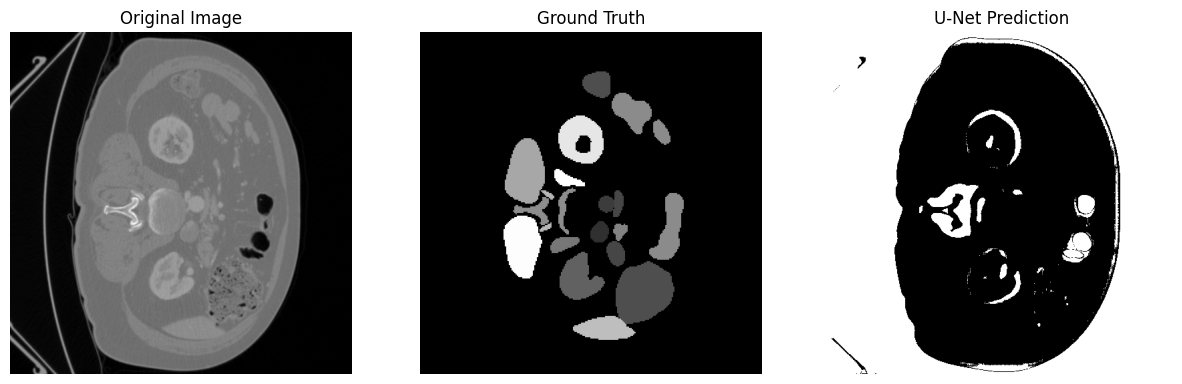

In [ ]:
def plot_comparison(original, ground_truth, prediction):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(original, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth, cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(prediction, cmap='gray')
    plt.title('U-Net Prediction')
    plt.axis('off')

    plt.show()

# Original image and its ground truth vs the prediction
plot_comparison(image_np, true_mask_np, predicted_mask_single_slice)


#### Well it's bad but it is an unoptimized Unet-like algorithm so let's stay hopeful !

In [1]:
## Let's see its overall score

In [ ]:
data_val = X_train_399[:100]
labels_val = Y_train_399[:100]
data_val = data_val.to(device)
labels_val = labels_val.to(device)

In [ ]:
from sklearn.metrics import adjusted_rand_score

def compute_predictions(dataset):
    Unet_model.eval()  # Set the model to evaluation mode
    predictions_list = []
    with torch.no_grad():  # Disable gradient calculation
        for data_slice in tqdm(dataset): # Add batch dimension
            output = Unet_model(data_slice)
            _, predicted = torch.max(output, 1)  # Get the index of the max log-probability
            predictions_list.append(predicted.squeeze().cpu().numpy())  # Remove batch dim and move to cpu
    return np.stack(predictions_list, axis=0)

# Compute predictions on the validation set
predictions_val = compute_predictions(data_val)

# Flatten the predictions and true labels for computing Rand index
predictions_val_flat = predictions_val.reshape((len(predictions_val), -1))
labels_val_flat = labels_val.cpu().numpy().reshape((len(labels_val), -1))

# Compute the rand index
def rand_index_dataset(y_true, y_pred):
    individual_rand_index = []
    for labels, preds in zip(y_true, y_pred):
        individual_rand_index.append(adjusted_rand_score(labels, preds))
    return np.mean(individual_rand_index)

# Compute the Rand index on the validation set
rand_index = rand_index_dataset(labels_val_flat, predictions_val_flat)
print(f"Average Rand Index on the Validation Set: {rand_index}")

100%|██████████| 100/100 [00:01<00:00, 81.76it/s]


Average Rand Index on the Validation Set: 0.12527986158866752


# Let's do something cleaner now for our Unet-like algo !

In [ ]:
from torch.utils.data import  random_split

# Dataset for the entire data
full_train = TensorDataset(X_train_399, Y_train_399)

# Splitting the dataset into training and validation
train_size = int(0.8 * len(full_train))
val_size = len(full_train) - train_size
train_dataset, val_dataset = random_split(full_train, [train_size, val_size])

In [ ]:
Unet_model2 = Unet(k=106, in_channels=1, filters=64)  # Set k to 106 for 106 classes
Unet_model2 = Unet_model2.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Unet_model2.parameters(), lr=1e-4, weight_decay=1e-8, foreach=True) # Best parameters I found after several tries

In [ ]:
batch_size = 8 # Still issues regarding GPU computational power

train_data = TensorDataset(X_train_399, Y_train_399)
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
#testloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size,shuffle=False, num_workers=2)

In [ ]:
num_epochs = 100

for epoch in range(num_epochs):
    Unet_model2.train()
    running_loss = 0.0
    num_batches = 0  # Keep track of the number of batches processed

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = Unet_model2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        num_batches += 1

    # Calculate the average training loss for the epoch
    avg_train_loss = running_loss / num_batches

    # Validation phase
    Unet_model2.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    num_val_batches = 0
    with torch.no_grad():  # No gradients needed for validation
        for data in val_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = Unet_model2(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            num_val_batches += 1

    # Calculate the average validation loss for the epoch
    avg_val_loss = val_loss / num_val_batches

    # Print the average losses for the current epoch
    print(f'Epoch {epoch + 1}, Training Loss: {avg_train_loss:.3f}, Validation Loss: {avg_val_loss:.3f}')

print('Finished Training')


Epoch 1, Training Loss: 4.156, Validation Loss: 3.961
Epoch 2, Training Loss: 3.673, Validation Loss: 4.526
Epoch 3, Training Loss: 3.451, Validation Loss: 3.497
Epoch 4, Training Loss: 3.263, Validation Loss: 2.548
Epoch 5, Training Loss: 3.091, Validation Loss: 2.256
Epoch 6, Training Loss: 2.940, Validation Loss: 3.042
Epoch 7, Training Loss: 2.794, Validation Loss: 2.026
Epoch 8, Training Loss: 2.665, Validation Loss: 2.069
Epoch 9, Training Loss: 2.532, Validation Loss: 1.747
Epoch 10, Training Loss: 2.405, Validation Loss: 1.717
Epoch 11, Training Loss: 2.293, Validation Loss: 2.873
Epoch 12, Training Loss: 2.191, Validation Loss: 1.622
Epoch 13, Training Loss: 2.109, Validation Loss: 1.579
Epoch 14, Training Loss: 2.001, Validation Loss: 1.575
Epoch 15, Training Loss: 1.913, Validation Loss: 1.566
Epoch 16, Training Loss: 1.845, Validation Loss: 1.533
Epoch 17, Training Loss: 1.770, Validation Loss: 1.437
Epoch 18, Training Loss: 1.701, Validation Loss: 1.465
Epoch 19, Training 

In [ ]:
data_val = X_train_399[:100]
labels_val = Y_train_399[:100]
data_val = data_val.to(device)
labels_val = labels_val.to(device)

In [ ]:

def compute_predictions(dataset):
    Unet_model2.eval()
    predictions_list = []
    with torch.no_grad():
        for data_slice in tqdm(dataset):  # Iterate over the dataset
            data_slice = data_slice.unsqueeze(0)
            data_slice = data_slice.to(device)
            output = Unet_model2(data_slice)
            _, predicted = torch.max(output, 1)
            predictions_list.append(predicted.squeeze().cpu().numpy())
    return np.stack(predictions_list, axis=0)

# Compute predictions on the validation set
predictions_val = compute_predictions(data_val)

# Flatten the predictions and true labels for computing Rand index
predictions_val_flat = predictions_val.reshape((len(predictions_val), -1))
labels_val_flat = labels_val.cpu().numpy().reshape((len(labels_val), -1))

# Function to compute the rand index
def rand_index_dataset(y_true, y_pred):
    individual_rand_index = []
    for labels, preds in zip(y_true, y_pred):
        individual_rand_index.append(adjusted_rand_score(labels, preds))
    return np.mean(individual_rand_index)

# Compute the Rand index on the validation set
rand_index = rand_index_dataset(labels_val_flat, predictions_val_flat)
print(f"Average Rand Index on the Validation Set: {rand_index}")

100%|██████████| 100/100 [00:01<00:00, 77.53it/s]


Average Rand Index on the Validation Set: 0.26210649515493484


### Much better than what we had !!! Let's see what it looks like

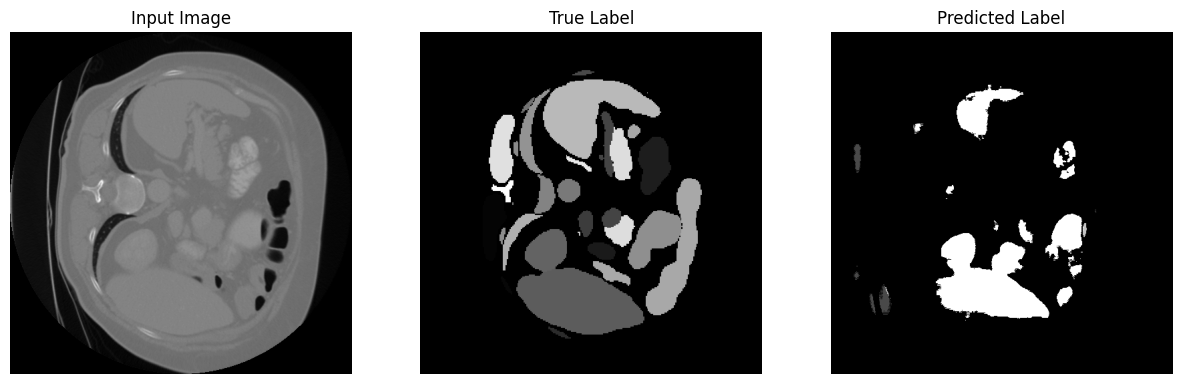

In [ ]:
import matplotlib.pyplot as plt

data_sample = X_train_399[2].unsqueeze(0)  # Add a batch dimension
data_sample = data_sample.to(device)

Unet_model2.eval()
with torch.no_grad():
    output = Unet_model2(data_sample)
    _, predicted = torch.max(output, 1)

# Move tensors to CPU for plotting
data_sample_cpu = data_sample.squeeze().cpu()  # Remove batch dimension and move to CPU
label_sample_cpu = Y_train_399[2].cpu()
predicted_cpu = predicted.squeeze().cpu()  # Remove batch dimension and move to CPU

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(data_sample_cpu, cmap='gray')
axs[0].set_title('Input Image')

axs[1].imshow(label_sample_cpu, cmap='gray')
axs[1].set_title('True Label')

axs[2].imshow(predicted_cpu, cmap='gray')
axs[2].set_title('Predicted Label')

for ax in axs:
    ax.axis('off')

plt.show()


In [ ]:
# Well of course that it is bad, what were you expecting from a 0.26 rand score !!
# At least we improved greatly our initial score and we see the beginning of a good recognition pattern from our algorithm
# I eventually ran out of Colab pro credits and without their GPUs I can't run any more examples... But it was fun to try !